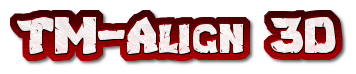
### Open-Source Pairwise Protein Structure Comparison and Visualization

This notebook allows you to compare two protein structures using **TM-score** and **RMSD (Root Mean Square Deviation)**, and visualize the alignment in 3D.

- **TM-score** is a length-independent metric that measures the topological similarity between two protein structures.  
  It was introduced in:  
  *Yang Zhang, Jeffrey Skolnick (2005). "TM-align: a protein structure alignment algorithm based on the TM-score." Nucleic Acids Research, 33(7), 2302–2309.*  
- **RMSD** measures the average atomic deviation between equivalent atoms after optimal superposition.  
  Lower RMSD values indicate a closer geometric match, while TM-score emphasizes global fold similarity.


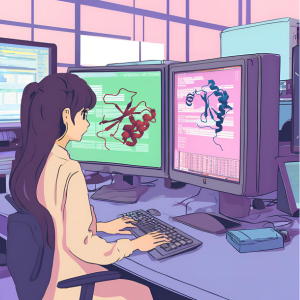
### Install Dependencies
⬇️ *Run the next two cells to install required libraries and mount your Google Drive before use.*



In [1]:
!pip install tmtools
!pip install py3Dmol
!pip install biopython
!pip install prody
!pip install requests

In [6]:
#@title Connect Google Drive (and fetch example PDBs: 4DAS, 6M52)
from google.colab import drive
from pathlib import Path
from datetime import datetime
import urllib.request

# 1) Mount Drive
drive.mount('/content/drive')
print("✅ Drive mounted:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# 2) Working folder
BASE_DIR = Path('/content/drive/My Drive/PhageHuntersPDB')
PDB_DIR  = BASE_DIR / 'pdbs'
PDB_DIR.mkdir(parents=True, exist_ok=True)
print("📂 Working folder:", PDB_DIR)

# 3) Ensure example structures exist (so defaults work out-of-the-box)
def fetch_pdb_if_needed(pdb_id: str):
    url = f"https://files.rcsb.org/download/{pdb_id.upper()}.pdb"
    out = PDB_DIR / f"{pdb_id.lower()}.pdb"
    if out.exists():
        print(f"✅ Already present: {out.name}")
        return
    try:
        with urllib.request.urlopen(url, timeout=20) as r, open(out, "wb") as f:
            f.write(r.read())
        print(f"⬇️ Saved: {out.name}")
    except Exception as e:
        print(f"⚠️ Failed to fetch {pdb_id}: {e}")

for pid in ("4DAS", "6M52"):
    fetch_pdb_if_needed(pid)

# 4) List what's available
print("\n📚 Files currently in /pdbs:")
for p in sorted(PDB_DIR.glob('*')):
    print(" -", p.name)

print("\n➡️ Add files by dragging them into Google Drive at:")
print("   My Drive ▸ PhageHuntersPDB ▸ pdbs  (then re-run this cell to refresh)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted: 2025-10-22 21:04:42
📂 Working folder: /content/drive/My Drive/PhageHuntersPDB/pdbs
⬇️ Saved: 4das.pdb
⬇️ Saved: 6m52.pdb

📚 Files currently in /pdbs:
 - 4das.pdb
 - 6m52.pdb

➡️ Add files by dragging them into Google Drive at:
   My Drive ▸ PhageHuntersPDB ▸ pdbs  (then re-run this cell to refresh)


In [9]:
#@title Align & Visualize Structures
fileA_name = "4das.pdb"   # @param {type:"string"}
fileB_name = "6m52.pdb"   # @param {type:"string"}
mode = "monomer"         # @param ["monomer","multimer"] {type:"string"}
opacity = 0.70            # @param {type:"number"}
show_label = True         # @param {type:"boolean"}
print_chains = False      # @param {type:"boolean"}

# --- normalize names (remove any quotes students might paste) ---
def _clean(s):
    return str(s).strip().strip('"').strip("'")
fileA_name, fileB_name = _clean(fileA_name), _clean(fileB_name)

import io, numpy as np
from pathlib import Path
from Bio.PDB import PDBParser, MMCIFParser, Superimposer, Select, PDBIO, is_aa
from tmtools import tm_align
from tmtools.io import get_structure as tm_get_structure, get_residue_data
import py3Dmol

BASE_DIR = Path('/content/drive/My Drive/PhageHuntersPDB')
PDB_DIR  = BASE_DIR / 'pdbs'
fileA = PDB_DIR / fileA_name
fileB = PDB_DIR / fileB_name
assert fileA.exists(), f"Not found: {fileA}"
assert fileB.exists(), f"Not found: {fileB}"

def parser_for(path: Path):
    return MMCIFParser(QUIET=True) if path.suffix.lower() in {'.cif','.mmcif'} else PDBParser(QUIET=True)

def first_poly_chain(structure):
    for m in structure:
        for c in m:
            if any(is_aa(r, standard=True) for r in c):
                return c.id
        break
    return next(next(structure.get_models()).get_chains()).id

def list_poly_chains(path: Path):
    s = parser_for(path).get_structure("S", str(path))
    out = []
    for m in s:
        for c in m:
            if any(is_aa(r, standard=True) for r in c):
                out.append(c.id)
        break
    return out

class KeepChains(Select):
    def __init__(self, keep=None): self.keep = set(keep) if keep else None
    def accept_chain(self, chain): return (self.keep is None) or (chain.id in self.keep)
    def accept_residue(self, residue): return True

def struct_to_pdb_text(struct, keep=None):
    buf = io.StringIO()
    io_writer = PDBIO()
    io_writer.set_structure(struct)
    io_writer.save(buf, select=KeepChains(keep))
    return buf.getvalue()

def get_ca_atoms(struct, chain_id):
    atoms = []
    m0 = next(struct.get_models())
    chain = m0[chain_id] if chain_id in [c.id for c in m0] else next(m0.get_chains())
    for res in chain:
        if is_aa(res, standard=True) and "CA" in res:
            atoms.append(res["CA"])
    return atoms

def apply_rotran_to_structure(struct, R, t, restrict=None):
    m0 = next(struct.get_models())
    for ch in m0:
        if restrict and ch.id not in restrict:
            continue
        for res in ch:
            for atom in res:
                atom.set_coord(np.dot(atom.coord, R) + t)

# --- load structures we will render ---
sA = parser_for(fileA).get_structure("A", str(fileA))
sB = parser_for(fileB).get_structure("B", str(fileB))
chainA = first_poly_chain(sA)     # monomer mode = A/A by default
chainB = first_poly_chain(sB)

if print_chains:
    print("Chains in", fileA.name, "→", list_poly_chains(fileA))
    print("Chains in", fileB.name, "→", list_poly_chains(fileB))

# --- Superimposer (tight visual overlay) on CA atoms of first chains ---
atomsA = get_ca_atoms(sA, chainA)
atomsB = get_ca_atoms(sB, chainB)
n = min(len(atomsA), len(atomsB))
atomsA, atomsB = atomsA[:n], atomsB[:n]

sup = Superimposer()
sup.set_atoms(atomsA, atomsB)   # fits B onto A
R, t = sup.rotran
rmsd = float(sup.rms)

# --- TM-score using tmtools on same chains (for the stat students expect) ---
def tm_inputs(path: Path, chain_id: str):
    tms = tm_get_structure(str(path))
    m0 = next(tms.get_models())
    ch = m0[chain_id] if chain_id in [c.id for c in m0] else next(m0.get_chains())
    coords, seq = get_residue_data(ch)
    return np.asarray(coords, float), seq
caA, seqA = tm_inputs(fileA, chainA)
caB, seqB = tm_inputs(fileB, chainB)
tmres = tm_align(caA, caB, seqA, seqB)  # B onto A
tm_score = float(getattr(tmres, "tm_norm_chain1", None) or getattr(tmres, "tm_score", None))

# --- build viewer models; MULTIMER -> transform ALL chains of B and render all chains of A/B ---
if mode == "multimer":
    apply_rotran_to_structure(sB, R, t, restrict=None)
    pdbA_txt = struct_to_pdb_text(sA, keep=None)
    pdbB_txt = struct_to_pdb_text(sB, keep=None)
    mode_str = "MULTIMER"
else:
    apply_rotran_to_structure(sB, R, t, restrict={chainB})
    pdbA_txt = struct_to_pdb_text(sA, keep={chainA})
    pdbB_txt = struct_to_pdb_text(sB, keep={chainB})
    mode_str = "MONOMER"

# --- visualize ---
view = py3Dmol.view(width=980, height=720)
view.addModel(pdbA_txt, 'pdb'); view.setStyle({'model':0},{'cartoon':{'color':'#e41a1c','opacity':float(opacity)}})
view.addModel(pdbB_txt, 'pdb'); view.setStyle({'model':1},{'cartoon':{'color':'#377eb8','opacity':float(opacity)}})
view.zoomTo()
if show_label:
    center = {'x': float(np.mean(caA[:,0])), 'y': float(np.mean(caA[:,1])), 'z': float(np.mean(caA[:,2]))}
    view.addLabel(f"TM-score: {tm_score:.3f} | RMSD: {rmsd:.2f} | Mode: {mode_str} | Chains: {chainA}/{chainB}",
                  center, {"fontSize":16, "backgroundColor":"black", "fontColor":"white", "backgroundOpacity":0.75})
view.show()

print(f"FileA: {fileA.name} (chain {chainA})")
print(f"FileB: {fileB.name} (chain {chainB})")
print(f"TM-score: {tm_score:.3f}   RMSD: {rmsd:.3f}   Mode: {mode_str}")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

FileA: 4das.pdb (chain A)
FileB: 6m52.pdb (chain A)
TM-score: 0.965   RMSD: 0.853   Mode: MONOMER


In [ ]:
#@title (Optional) Sequence Information

from pathlib import Path
from Bio.PDB import PDBParser, MMCIFParser, is_aa
from tmtools.io import get_structure as tm_get_structure, get_residue_data
from Bio.Align import substitution_matrices, PairwiseAligner
from IPython.display import HTML, display
import html

BASE_DIR = Path('/content/drive/My Drive/PhageHuntersPDB')
PDB_DIR  = BASE_DIR / 'pdbs'

def _clean(s): return str(s).strip().strip('"').strip("'")
fileA = (PDB_DIR / _clean(fileA_name))
fileB = (PDB_DIR / _clean(fileB_name))
assert fileA.exists() and fileB.exists(), "Make sure the files exist in /pdbs."

def parser_for(path: Path):
    return MMCIFParser(QUIET=True) if path.suffix.lower() in {'.cif','.mmcif'} else PDBParser(QUIET=True)

def first_poly_chain(structure):
    for m in structure:
        for c in m:
            if any(is_aa(r, standard=True) for r in c):
                return c.id
        break
    return next(next(structure.get_models()).get_chains()).id

# --- get sequences for first polymer chains (same as 3D cell) ---
def get_chain_seq(path: Path):
    tms = tm_get_structure(str(path))
    m0  = next(tms.get_models())
    s = parser_for(path).get_structure("S", str(path))
    chain_id = first_poly_chain(s)
    ch = m0[chain_id] if chain_id in [c.id for c in m0] else next(m0.get_chains())
    _, seq = get_residue_data(ch)
    return chain_id, "".join(seq)

chainA_id, seqA = get_chain_seq(fileA)
chainB_id, seqB = get_chain_seq(fileB)

# --- global alignment using modern PairwiseAligner ---
matrix = substitution_matrices.load("BLOSUM62")
aligner = PairwiseAligner()
aligner.substitution_matrix = matrix
aligner.open_gap_score = -10
aligner.extend_gap_score = -0.5
alignments = aligner.align(seqA, seqB)
aln = alignments[0]
alA, alB = aln.aligned

# Build expanded alignment strings
alignedA, alignedB = [], []
iA = iB = 0
for segA, segB in zip(alA, alB):
    while iA < segA[0]:
        alignedA.append(seqA[iA]); alignedB.append('-'); iA += 1
    while iB < segB[0]:
        alignedA.append('-'); alignedB.append(seqB[iB]); iB += 1
    while iA < segA[1] and iB < segB[1]:
        alignedA.append(seqA[iA]); alignedB.append(seqB[iB]); iA += 1; iB += 1
# finish tails
alignedA.extend(list(seqA[iA:]))
alignedB.extend(list(seqB[iB:]))
alA_str, alB_str = "".join(alignedA), "".join(alignedB)

# --- stats ---
lenA, lenB = len(seqA), len(seqB)
aligned_positions = sum((a != '-') and (b != '-') for a, b in zip(alA_str, alB_str))
identical = sum((a == b) and (a != '-') for a, b in zip(alA_str, alB_str))
identity_pct = 100.0 * identical / aligned_positions if aligned_positions else 0.0

print(f"FileA: {fileA.name} (chain {chainA_id}) | Length: {lenA}")
print(f"FileB: {fileB.name} (chain {chainB_id}) | Length: {lenB}")
print(f"Aligned residues (no gaps in either): {aligned_positions}")
print(f"Identical positions: {identical}  ({identity_pct:.1f}%)")

# --- CLUSTALW coloring ---
CLUSTALW_COLORS = {
    **{aa: "#3b82f6" for aa in "ACILMFWV"},   # hydrophobic
    **{aa: "#ef4444" for aa in "KR"},         # positive
    **{aa: "#d946ef" for aa in "ED"},         # negative
    **{aa: "#22c55e" for aa in "NQST"},       # polar
    "C": "#ec4899", "G": "#f59e0b", "P": "#eab308",  # specials
    **{aa: "#06b6d4" for aa in "HYFW"}        # aromatic
}
GAP_COLOR = "#9ca3af"

def color_for_res(res):
    if res == "-": return GAP_COLOR
    return CLUSTALW_COLORS.get(res.upper(), "#94a3b8")

def colorize_line(seq):
    return "".join(
        f'<span style="background:{color_for_res(ch)}; color:#111; padding:2px 3px; '
        f'border-radius:2px; font-family:monospace">{html.escape(ch)}</span>'
        for ch in seq
    )

cons_line = "".join(
    '<span style="color:#111">|</span>' if a == b and a != '-' else
    ('&nbsp;' if a == '-' or b == '-' else '<span style="color:#999">.</span>')
    for a, b in zip(alA_str, alB_str)
)

html_out = f"""
<div style="font-family:Inter,system-ui,Segoe UI,Arial,sans-serif; line-height:1.6">
  <h4 style="margin:0 0 6px">(Optional) Sequence alignment (CLUSTALW colors)</h4>
  <div style="font-size:13px; margin-bottom:8px">
    <b>{html.escape(fileA.name)}</b> (chain {chainA_id}) · length {lenA}<br/>
    <b>{html.escape(fileB.name)}</b> (chain {chainB_id}) · length {lenB}<br/>
    Aligned residues: <b>{aligned_positions}</b> | Identical: <b>{identical}</b> ({identity_pct:.1f}%)
  </div>
  <div style="font-family:monospace; white-space:nowrap; overflow:auto; padding:8px; border:1px solid #444; border-radius:6px;">
    {colorize_line(alA_str)}<br/>
    {cons_line}<br/>
    {colorize_line(alB_str)}
  </div>
  <div style="font-size:12px; opacity:0.8; margin-top:6px">
    Legend: hydrophobic = blue; + charged = red; − charged = magenta; polar = green;
    Cys = pink; Gly = orange; Pro = yellow; aromatic (H/Y/F/W) = cyan; gaps = gray.
  </div>
</div>
"""
display(HTML(html_out))


FileA: 4das.pdb (chain A) | Length: 172
FileB: 6m52.pdb (chain A) | Length: 171
Aligned residues (no gaps in either): 171
Identical positions: 116  (67.8%)


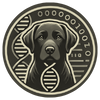
<hr style="border: none; height: 1px; background: linear-gradient(to right, transparent, #666, transparent); margin: 20px 0;">

<div align="center" style="line-height:1.6;">

**Developed by**  
**Joel D. Prabakaran**, **Aniket Camarushi**, **Jonah Petty**, **Jeshuwin D. Prabakaran**  
**University of Maryland, Baltimore County**  
**Bioinformatics and Computational Biology Association (BCBA)**

</div>

<hr style="border: none; height: 1px; background: linear-gradient(to right, transparent, #666, transparent); margin: 20px 0;">
